##### Required dependencies

In [26]:
from keras import datasets, layers, models, utils, callbacks
import tensorflow as tf
import joblib

import matplotlib.pyplot as plt
import numpy as np

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### Load CIFAR-100 dataset

In [13]:
(X_train, y_train), (X_test, y_test) = datasets.cifar100.load_data(label_mode="fine")

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# split data for validation
X_val = X_train[45000:]
X_train = X_train[:45000]

y_val = y_train[45000:]
y_train = y_train[:45000]

assert X_train.shape == (45000, 32, 32, 3)
assert y_train.shape == (45000, 1)
assert X_val.shape == (5000, 32, 32, 3)
assert y_val.shape == (5000, 1)
assert X_test.shape == (10000, 32, 32, 3)
assert y_test.shape == (10000, 1)

y_train = tf.one_hot(y_train, 
                     depth=y_train.max() + 1, 
                     dtype=tf.float64) 
y_val = tf.one_hot(y_val, 
                   depth=y_val.max() + 1, 
                   dtype=tf.float64) 

y_train = tf.squeeze(y_train) 
y_val = tf.squeeze(y_val)

##### Visualize dataset

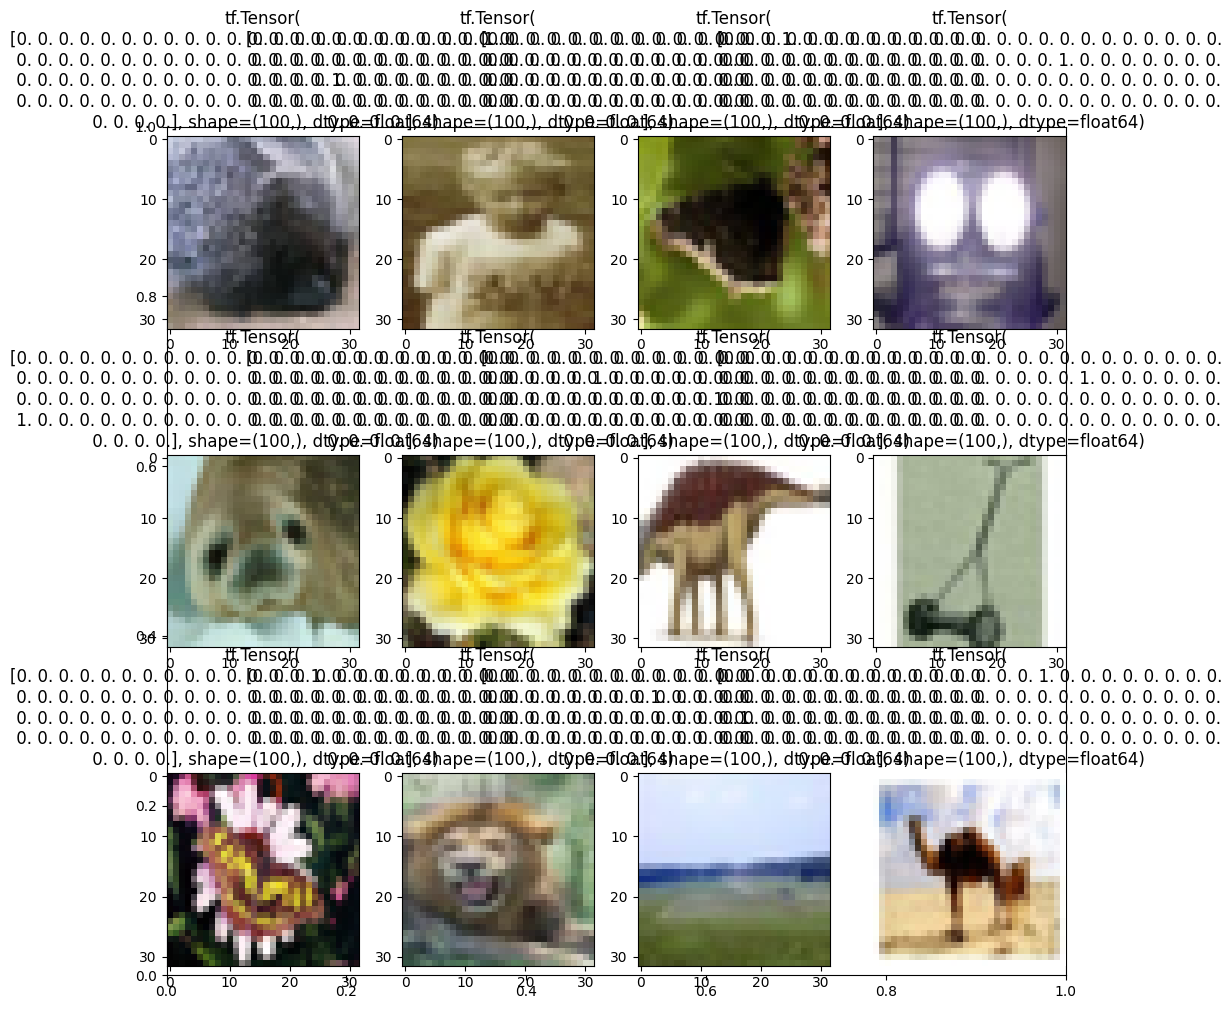

In [16]:
def show_samples(data, labels): 
    plt.subplots(figsize=(10, 10)) 
    for i in range(12): 
        plt.subplot(3, 4, i+1) 
        k = np.random.randint(0, data.shape[0]) 
        plt.title(labels[k]) 
        plt.imshow(data[k])
        
    plt.tight_layout()
    plt.axis("off")
    plt.show()
  
show_samples(X_train, y_train)

##### Build Model

In [21]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'), 
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3), 
        layers.BatchNormalization(), 
        layers.Dense(100, activation='softmax')
    ])
    
    model.compile( 
        loss="categorical_crossentropy", 
        optimizer="adam", 
        metrics=["accuracy"] 
    )

    return model

In [30]:
import os

# Load check points
checkpoint_filepath = "checkpoints/cifar100.model.keras"
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

model = None
if os.path.exists(checkpoint_filepath):
    model = models.load_model(checkpoint_filepath)
    print("Model loaded from {}".format(checkpoint_filepath))
else:
    model = build_model()
    print("Build new model")

model.summary()

# Training
EPOCHS = 10
model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback],
    validation_data=(X_val, y_val)
)

Model loaded from checkpoints/cifar100.model.keras


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,737,486 (98.18 MB)

 Trainable params: 8,578,820 (32.73 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 17,157,642 (65.45 MB)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 62s 43ms/step - accuracy: 0.3280 - loss: 2.6562 - val_accuracy: 0.2964 - val_loss: 2.9165
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.3347 - loss: 2.6221 - val_accuracy: 0.3194 - val_loss: 2.7894
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 41ms/step - accuracy: 0.3426 - loss: 2.6041 - val_accuracy: 0.3182 - val_loss: 2.7941
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 96s 68ms/step - accuracy: 0.3453 - loss: 2.5905 - val_accuracy: 0.3330 - val_loss: 2.7177
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 74s 52ms/step - accuracy: 0.3519 - loss: 2.5539 - val_accuracy: 0.3298 - val_loss: 2.7334
Epoch 6/10
   5/1407 ━━━━━━━━━━━━━━━━━━━━ 1:08 49ms/step - accuracy: 0.3514 - loss: 2.5526

KeyboardInterrupt: 